In [142]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 17
### Team Member Names: John, Gen, Tim
### Team Strategy Chosen: Risky 

Requirements for this assignment:
- Code needs to be dynamic
- Must read in a csv file containing a finite number of stock tickers (with an example csv file in this repo)
- Portfolio must contain only US listed stocks
- Must have an average daily volume of at least 10 000 shares as calculated based on the time interval July 2, 2021 to October 22, 2021
- Pick a minimum 10 maximum 20 stocks for portfolio.
- If we choose n stocks, each stock must make up minimum (100/(2n))% of the portfolio when weighted by value as of closing prices on November 26, 2021
- No individual stock may make up more than 35% of the portfolio when weighted by value
- We have $100000 USD to spend on portfolio and all must be spent
- When code is run with the .csv file, it must create a DataFrame "FinalPortfolio"
    - With this portfolio, index starts at 1 and ends at the number of stocks that our code chooses.
    - Headings must be: Ticker, Price, Shares, Value, Weight
        - Ticker is the ticker selected
        - Price is the price on November 26, 2021
        - Shares is the number of shares purchased (can be fractional)
        - Value is the total value of those shares
        - Weighted is the weight that the value of shares represents relative to the value of the portfolio (which is $100,000)
    - Needs to show that the total adds up to $100,000
    - Also need to show the weights add to 100%
    - This DataFrame must be printed to the screen as the second to last output to the screen.
- After the DataFrame, one final DataFrame called "Stocks" which has the same index as "Final Portfolio" must be made
    - Only has the Tickers and Shares from "Final Portfolio"
    - Must output this DataFrame to a csv file titled "Stocks_Group_XX.csv"

## **General Strategy**:

#### Preparation
0) Define given variables and other imporant global variables

#### Part #1: Data Cleansing and Filtering
1) Filter out all valid US Stocks from the provided CSV file
2) Store the price and volume info of tickers in global dataframe
3) Filter out tickers within date range based on daily average volume

#### Part #2: Portfolio Construction
4) Obtain the 20 most volatile stocks (based on Standard Deviation)
5) Find the porfolio of 10 stocks with the highest correlation
6) STEP 6: Find the distributions of the weight that maximizes portfolio Standard Deviation

#### Part #3: Proof and Analysis
7) Graph the portfolio standard deviation for different weighting distributions
8) Given the chosen portfolio, measure its performance against the price weighted index consisting of all filtered US Stocks
9) Given the chosen portfolio of 10 stocks, graph the change in portfolio standard deviation as other risky stocks (not chosen in Step 5) are added in

#### Part #4: Final Output
10) Creating the final portfolio dataframe and csv

## Part #1: Data Cleansing and Filtering


### Step #0: Define important default and global variables (optimizing time and memories)
We will define a global variable 'all_price_df' that tracks the daily closing price and daily volume of all valid US stocks. Many functions will directly access this global dataframe during calculations, to avoid passing large dataframes as parameters, which is inefficient.

**NOTE** that all calculations will be performed on the daily interval, since first of all, data is very limited, thus not supporting calculation with dispersed interval. Yet, most importantly, the competition is held only for 7 days, therefore gauging the historical daily fluctuation of stocks better serves the purpose for this specific competition.

In [143]:
# Import default information
start_date = '2021-07-02'
end_date = '2021-10-23' # So that 2021-10-22 is included in the data
provided_csv = 'Tickers.csv'
min_avg_daily_volume = 10000
min_stock_count = 10
max_stock_count = 20

# Stores all valid US tickers as yfObjects!!!!
us_stock_lst = []

# Stores the closing price and volume of tickers
all_price_df = pd.DataFrame()

### Step #1: Filter out valid US tickers
Use threading technique to quickly filter out all valid US stock in the given csv.

In [144]:
stocks_from_csv = pd.read_csv(provided_csv, header=None) # Use header=Noned to read in the first row
stocks_lst = stocks_from_csv.iloc[:,0]

In [145]:
# import the modules needed for threading
import concurrent.futures

# Clears the global variable in case of previous stored info (when re-executing cells)
us_stock_lst = []

# Add valid stocks to the us_stock_lst
def filter_valid(ticker_name):
    try:
        ticker_yf = yf.Ticker(ticker_name) # Store as variable to optimize access time
        if (ticker_yf.info['regularMarketPrice'] != None) and (ticker_yf.info['market'] == 'us_market'):
            us_stock_lst.append(ticker_yf)

    except requests.exceptions.RequestException as e:
       return e
 
# Function to call threading
def runner():
    threads= []
    with concurrent.futures.ThreadPoolExecutor(max_workers=80) as executor:
        for name in stocks_lst:
            threads.append(executor.submit(filter_valid, name))

# Calls function, us_stock_lst will be filled
runner()

In [146]:
# A quick check of the content in the us_stock_lst
len(us_stock_lst)

55

### Step #2: Store the price and volume info of tickers in global dataframe

Use threading to store the daily closing price and daily volume of all valid US ticker tp global dataframe 'all_price_df'.

In [147]:
# Find the data of a particularly stock
def ticker_to_df(ticker_yf):
    # Access the ticker symbol of the ticker
    symbol = ticker_yf.info['symbol']

    # If the ticker is not yet included, we return its info
    if symbol not in all_price_df:
        temp_df = ticker_yf.history(start=start_date, end=end_date)[['Close', 'Volume']]
        temp_df = temp_df.rename(columns={'Close' : symbol, 'Volume' : f'{symbol}_Vol'})
        return temp_df
    # Otherwise return an empty dataframe, so all_price_df will not be changed
    return pd.DataFrame()

# Use threading to update the global price dataframe
def update_price_df(ticker_lst):
    with concurrent.futures.ThreadPoolExecutor(max_workers=80) as executor:
        results = executor.map(ticker_to_df, us_stock_lst)

    # Load in the global dataframe
    global all_price_df

    # Update the global dataframe based on the statistic info of each ticker
    for result in results:
        all_price_df = pd.concat([all_price_df, result], axis=1)

In [148]:
# Call the function to fill all_price_df
update_price_df(us_stock_lst)

# A quick check of the content in the all_price_df
all_price_df.tail()

,PG,PG_Vol,MSFT,MSFT_Vol,C,C_Vol,BK,BK_Vol,AXP,AXP_Vol,...,UPS,UPS_Vol,AMZN,AMZN_Vol,T,T_Vol,ABBV,ABBV_Vol,MRK,MRK_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-18,141.463242,9119000,307.290009,22729300,71.094749,15026100,57.081612,5218900,176.820007,2623300,...,192.439224,2305000,3446.739990,3174100,25.33,45171900,107.430000,7949400,77.150002,13075500
2021-10-19,139.793594,9555300,308.230011,17682100,71.243675,15173900,57.320240,5765200,177.309998,1400100,...,192.837250,1974500,3444.149902,2386100,25.59,34926500,107.449997,4614900,79.489998,15577100
2021-10-20,140.340210,7352700,307.410004,16537100,71.303238,14350400,58.970745,6276100,179.600006,2398500,...,194.309982,1952000,3415.060059,2139800,25.91,48283400,108.410004,5626800,81.070000,11465500
2021-10-21,139.330002,6545500,310.760010,16918100,70.002663,18519000,59.398285,4178100,177.470001,3313800,...,198.459488,2997300,3435.010010,1881400,25.76,55827800,108.760002,4811800,81.169998,9893600
2021-10-22,140.830002,5265000,309.160004,17449300,70.856476,14625100,59.368454,4978500,187.080002,6026100,...,202.807999,3735900,3335.550049,3139100,25.49,37129300,109.139999,4614400,81.150002,7543600


### Step #3: Filter out tickers within date range based on daily average volume

Iterates through each ticker in the 'us_stock_lst' and check if they are valid. Access the daily volume in 'all_price_df'.

In [149]:
# Finds the average daily volume of a stock
def avg_daily_volume(ticker):
    # Load the global price dataframe
    global all_price_df

    # Calculate and return the average volume
    return all_price_df[f'{ticker}_Vol'].mean()
    
# Iterates through us_stock_lst and checks if the stock has
# an average daily volume of at least the minimum given
def volume_filter():
    # Define a list to store the valid tickers
    valid_stock_list = []

    # Find the ticker that meets the criteria
    for i in us_stock_lst:
        if avg_daily_volume(i.info['symbol']) >= min_avg_daily_volume:
            valid_stock_list.append(i)
    
    # Return all valid stocks
    return valid_stock_list

# Find the stocks that meet the criteria
filtered_stocks = volume_filter()

In [150]:
# A quick check of the content in the filtered_stocks
len(filtered_stocks)

55

## Part #2: Portfolio Construction

### Step #4: Obtain the 20 most volatile stocks (based on Standard Deviation)
Calculate the Standard Deviation of the returns of each stock in 'filtered_stocks' and find the 20 with the highests Standard Deviation. The parameter of 20 is specifically chosen since the maximum number of stocks to be included in a portfolio is 20.

In [151]:
# Variable to store the number of most volatile stocks we wish to find
volatile_sample = max_stock_count

# ticker_lst will always be filtered_stocks in yfObjects
def find_volatile (stock_count, ticker_lst): 
    # Load in global price df
    global all_price_df

    # Find the list of filtered symbols
    ticker_symbol = []
    for i in ticker_lst:
        ticker_symbol.append(i.info['symbol'])

    share_prices = all_price_df[ticker_symbol]

    #Convert our dataframe into simply one column with standard deviation 
    sd_of_shares = share_prices.pct_change().std()

    #Have to convert sd_of_shares into a dataframe
    sd_df = pd.DataFrame(sd_of_shares)

    #Find the 20 largest standard deviations meaning the most volatile
    column = sd_df[0]
    largest_names = []
    for i in range (stock_count):
        largest_names.append(column.idxmax())
        column = column.drop([column.idxmax()])

    return largest_names

largest_volatile = find_volatile(volatile_sample, filtered_stocks)

# Display
print('The top 20 volatile tickers are:\n', largest_volatile)

The top 20 volatile tickers are:
 ['OXY', 'SLB', 'GM', 'COP', 'COF', 'BA', 'PYPL', 'AIG', 'SPG', 'AXP', 'BIIB', 'BAC', 'USB', 'BK', 'KMI', 'CAT', 'MS', 'AMZN', 'PFE', 'C']


### Step #5: Find the porfolio of 10 stocks with the highest correlation
Take the first 15 (or all if there is less than 15) volatile stocks, and iterate through all portfolio combinations of 10 stocks to find the portfolio with the highest average correlation.

The average correlation is simply the average value of each pair-wise correlation of the stocks in a portfolio. This helps us to find a portfolio that is highly correlated, apart from being very volatile. Thus, the volatility in each individual stocks will not cancel out, for instance, when one stock fluctuates in an upward trend and the other in the opposite direction.

The rationale behind taking only the first 15 tickers is that first of all, we want tickers that are very volatile. More importantly, this help to reduce computation time. Specifically, choosing a portfolio of 10 tickers from 15 tickers would yield 3003 combinations (15 choose 10). On other hand, if we choose a portfolio of 10 from all 20 tickers would require 184756 combinations (20 choose 10), which takes a lot more time.

In [152]:
### Find all possible combinations of n tickers within the ticker_lst using a recursive function
def combinations(arr, length, pre_arr=[]):
    # If the store arr reaches the length required, return it
    if len(pre_arr) == length:
        return [pre_arr]
    
    combs = []
    # Add each element to the previous array
    for i in range (len(arr)):
        cur_copy = pre_arr.copy()
        cur_copy.append(arr[i])
        # Find combinations that yields by adding the remaining ticker spots to stored array of chosen tickers
        combs += combinations(arr[i+1:], length, cur_copy)
    return combs

In [153]:
# Find the correlation matrix of all 20 stocks
price_df = all_price_df[largest_volatile]
price_df = price_df[(start_date <= price_df.index) & (price_df.index <= end_date)]
df_corr = price_df.corr()

# Function that finds the average correlation between stocks in a given portfolio
def find_avg_corr(ticker_lst):   
    # Calculate the avg corr
    sum_corr = 0
    sum_count = 0
    # Iterate through the pair_wise correlation and summing it up
    for i in range (len(ticker_lst)):
        for j in range (i+1, len(ticker_lst)):
            sum_corr += df_corr.loc[ticker_lst[i],ticker_lst[j]]
            sum_count += 1
    
    # Calculate the return the avg correlation
    return (sum_corr/sum_count)


In [154]:
# Find the combinaton of tickers with the maximum avg correlation
def find_max_correlation(ticker_lst, result_size = min_stock_count):
    # Store the maximum value of corr and the portfolio
    max_avg_corr = -1
    max_corr_ticker_lst = np.array([])
    
    # Load the global price dataframe
    global all_price_df
    
    # Convert list to array and find the combinations
    comb = combinations(np.array(ticker_lst), result_size)
        
    # Find the comb with the maximum average correlation
    for i in comb:
        avg_corr = find_avg_corr(i)
        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            max_corr_ticker_lst = i
    
    # Return the result sample
    return max_avg_corr, max_corr_ticker_lst

In [155]:
# Take the first 15 most volatile stocks, or all if there is not enough for 15
take_ticker_up_to = min(len(largest_volatile), 15) 
ticker_lst = largest_volatile[0 : take_ticker_up_to]

# Find the combination of tickers with maximum correlation
max_avg_corr, max_corr_ticker_lst = find_max_correlation(ticker_lst)

# Display
print('The maximum avg correlation is:', max_avg_corr)
print('The portfolio with maximum avg correlation is:', max_corr_ticker_lst)

The maximum avg correlation is: 0.6184563708330199
The portfolio with maximum avg correlation is: ['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'AXP', 'BAC', 'USB', 'BK']


### Step #6: Find the distributions of the weight that maximizes portfolio Standard Deviation

Use an exhaustive method of find the optimal weighting, that is to test many combinations of weighting and find the one with the highest Portfolio Standard Deviation.

First, we vary the weighting by increments from the min_weight to the max_weight. Our default number_of_increment will be 8 for a suitable computation time. 

Moreover, we only vary the weighting of the first 5 (varied_count) volatile tickers, and the remaining tickers will have a default weighting of min_weight. The number of combinations of weighting is equal to the varied_count to the power of number_of_increment. Therefore, only varying the first 5 yield a total of 5^8 = 390625 combinations, which is far faster than varying all 10 weightings, which takes 10^8 = 100000000.

In [156]:
### Define important variables
ticker_count = len(max_corr_ticker_lst) # Should be 10
varied_count = int(ticker_count / 2) # Should be 5
min_weight = 1/(2*ticker_count) 
max_weight = 0.35
number_of_increment = 8
increment = (max_weight - min_weight)/number_of_increment

In [157]:
### Define a function for calculation of portfolio Standard Deviation
def portfolio_cal_std(tickers, weights, start_date, end_date, investment=100000):
    # Load the global variable price dataframe
    global all_price_df
    
    # Store the size of tickers as a variable
    ticker_count = len(tickers)
    
    # Store the price information of the tickers in a new df
    port_df = all_price_df[(start_date <= all_price_df.index) & (all_price_df.index <= end_date)][tickers]
    
    # Find the value of each ticker using the shares brought on the first date
    for i in range (ticker_count):
        shares = (investment * weights[i] / port_df.loc[start_date, tickers[i]])
        port_df[tickers[i]] = port_df[tickers[i]] * shares

    # Calculate percentage returns
    port_df['Percent_Return'] = port_df[tickers].sum(axis=1).pct_change() * 100

    # Calculate and return the portfolio standard deviation
    return port_df['Percent_Return'].std()

In [158]:
# Define variables
all_std = []
max_std = -1
optimal_weights = []
check_count = 0

# Recursion: update max_std with the maximum recorded std, and fill in the list of all_std
def find_weight(cur_index, weights, remaining_weight):
    # Load global varables
    global ticker_count, varied_count, all_std, max_std, optimal_weights, check_count
    
    # Already assigned last ticker's weights
    if (cur_index == ticker_count):
        if (remaining_weight != 0): return

        # Display for confirmation that code works
        check_count += 1
        if (check_count % 1000 == 0): 
            print(f'Already Checked {check_count} Weighting Distributions.')

        # Calculate portfolio Std
        std = portfolio_cal_std(max_corr_ticker_lst, weights, start_date, end_date)
        
        # Store and find max std
        all_std.append(std)
        if (std > max_std):
            max_std = std
            optimal_weights = weights
        
        # End recursion since this is last index (aka last ticker to assign weights)
        return
    
    # The weight for the remaining ticker will not be varied
    if (cur_index >= varied_count):
        find_weight(cur_index + 1, weights + [min_weight], remaining_weight)
    # ELSE: assign weighting for this stock at the cur_index
    else: 
        # Store the extra weight given to this stock beyond the minimum weight
        cur_extra_weight = 0

        # Make sure the extra_weight will not cause to stock to excess max_weight
        while (cur_extra_weight <= max_weight - min_weight):
            # Stores the weight given to the current ticker, starts at min_weight
            ticker_weight = min_weight

            # Check if the extra weight given will exceed the remaining distributable weights
            if (cur_extra_weight > remaining_weight):
                ticker_weight += remaining_weight

                # Recursively calls the function to assign weights for the next ticker
                find_weight(cur_index + 1, weights + [ticker_weight], 0)
                break
        
            # ELSE: extra weight does not exceed the remaining weight to be distributed
            ticker_weight += cur_extra_weight
            
            # Recursively calls the function to assign weights for the next ticker
            find_weight(cur_index + 1, weights + [ticker_weight], remaining_weight - cur_extra_weight)

            # Increments for next iteration
            cur_extra_weight += increment

In [159]:
# Find the best weighting distribution
find_weight(0, [], 1 - ticker_count * (min_weight))

Already Checked 1000 Weighting Distributions.
Already Checked 2000 Weighting Distributions.
Already Checked 3000 Weighting Distributions.


In [160]:
print('The highest recorded std is', max_std)
print('The ticker in the portfolio and corresponding weights:')
max_corr_ticker_lst, optimal_weights

The highest recorded std is 2.115425751221299
The ticker in the portfolio and corresponding weights:


(['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'AXP', 'BAC', 'USB', 'BK'],
 [0.35, 0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

## Part #3: Proof and Analysis


### Step #7: Graph the portfolio standard deviation for different weighting distributions

We will graph all the recorded Portfolio Standard Deviation in a histogram to show how volatile of the portfolio if it was distributed otherwise.

**NOTE:** This graph should exhibits a normal distribution (more in the middle; less on the sides). Therefore, if the weight is chosen randomly, it is very unlikely that the Portfolio Standard Deviation is maximized. This proves that the exhausive method of weighting distribution is necessary to find the best portfolio, as outlined by the red line.

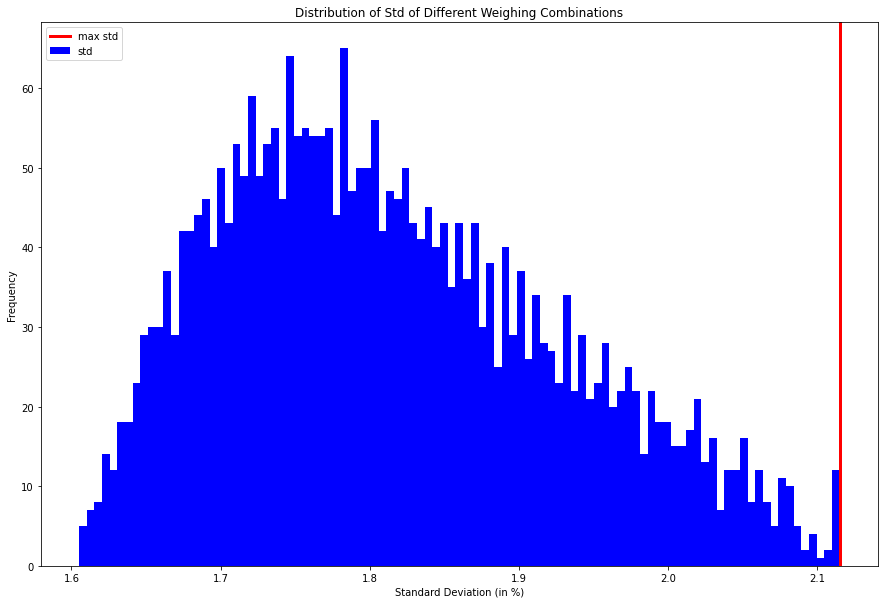

In [161]:
### Use a histogram to show the std of other weightings
# Create the interval classes
bins_max = max(all_std)
bins_min = min(all_std)
bins_intervals = 100
bins = np.linspace(bins_min, bins_max, bins_intervals)

# Create the histogram
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(all_std, bins, color='b', label='std')
plt.axvline(x=max_std, color='r', label='max std', linewidth=3)

# Formatting
plt.title("Distribution of Std of Different Weighing Combinations")
plt.xlabel("Standard Deviation (in %)")
plt.ylabel("Frequency")
plt.legend(loc='best')

# Display
plt.show()

## Part #4: Final Output


### Step 9 Graphing the change in standard deviaiton as we add more stocks into our portfolio

Text(0, 0.5, 'Standrad Deviaiton')

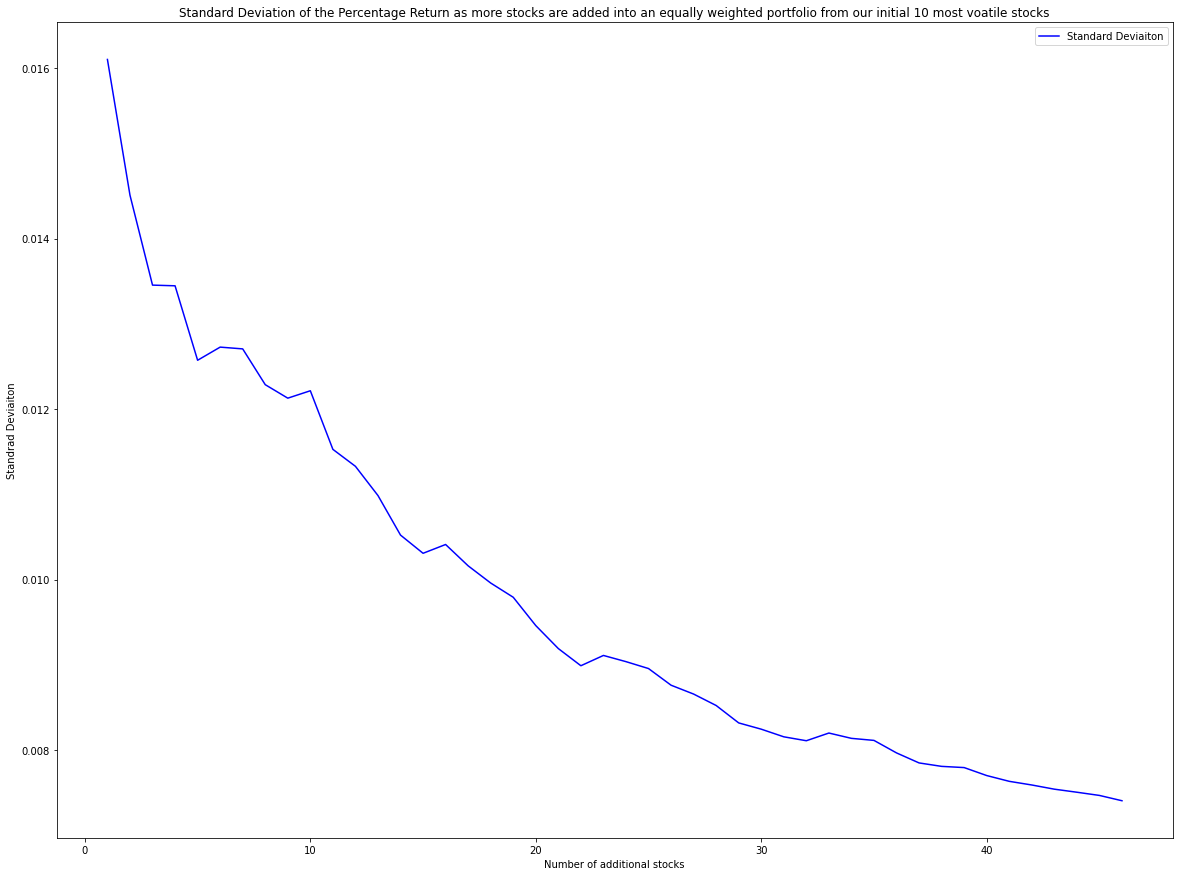

In [162]:
### Step #9: Given the chosen portfolio of 10 stocks, graph the change in portfolio standard deviation as other risky stocks (from the 10 that weren’t chosen in Step 4) are added in
max_corr_ticker_lst
#Will beging to remove stocks 
rest_of_stocks = filtered_stocks.copy()

#Filter out max_corr_lst
for y in range (len (max_corr_ticker_lst)):

    for u in range (len (rest_of_stocks)-1):

        if (max_corr_ticker_lst[y] == rest_of_stocks[u].info['symbol']):
            rest_of_stocks.pop(u)
max_corr_ticker_lst
rest_of_stocks
#Array with just the stock names
rest_of_stocks_name = []
for g in rest_of_stocks:
    rest_of_stocks_name.append(g.info['symbol'])

rest_of_stocks_name
#Array that contains all of the stocks names Will be used later on for reference
all_stock_names = rest_of_stocks_name + max_corr_ticker_lst

all_stock_names
#Begin to try to make the code block below recursive
#Need to make it accumulatively recursive

SD_array = []

def find_std(dataframe, num_list_of_stocks):
    portfolio_std = dataframe.pct_change().std()[num_list_of_stocks-1]

    SD_array.append(portfolio_std)
    
def collect_multiple_std(initial_10, stocks_add_on): #stocks_add_on needs to be rest_of_stocks_name
    global all_price_df

    collection_of_dataframes = []
    
    #Just the dataframe with 10 stocks
    for g in initial_10:
        collection_of_dataframes.append(pd.DataFrame(all_price_df.loc[:,g]))
    
    shares_10_df = pd.concat(collection_of_dataframes, join='inner', axis=1)
    #Up to here works 100%

    #Calculates number of stocks I need
    money_per_stock = 100000/10
    
    #Number of shares
    num_shares = []
    for h in range(len(initial_10)):
        num_shares.append(money_per_stock / shares_10_df.iloc[0,h])
    
    #Create the portfolio value
    portfolio_value = 0
    for k in range(len(initial_10)):
        portfolio_value = portfolio_value + num_shares[k]*shares_10_df.iloc[:,k]  

    data = {'Date': shares_10_df.index,
            'Portfolio_Value': portfolio_value}
    
    portfolio_frame = pd.DataFrame(data)
    
    portfolio_dataframe_10= pd.concat([shares_10_df, portfolio_frame], join='inner', axis=1)
    
    #Drop the duplicate column
    portfolio_dataframe_10.drop(columns=['Date'], inplace=True)  
    find_std(portfolio_dataframe_10, len(portfolio_dataframe_10.columns))

    #Up to here works 100%

    ## Now make the loop to make more stocks
    current_frame_array = [shares_10_df.copy()]
    for g in range (len (stocks_add_on)):
        next_frame = (pd.DataFrame(all_price_df.loc[:,stocks_add_on[g]]))
        current_frame_array.append(next_frame)
            
        current_frame = pd.concat(current_frame_array, join='inner',axis=1)
        
        #Amount of money per stock
        money_per_stock = 100000 / len(current_frame.columns)
    
        #Number of shares
        num_shares = []
        for h in range(len(current_frame.columns)):
            num_shares.append(money_per_stock / current_frame.iloc[0,h])
        
        #Create the portfolio value
        portfolio_value = 0
        for k in range(len(current_frame.columns)):
            portfolio_value = portfolio_value + num_shares[k]*current_frame.iloc[:,k]  

        data = {'Date': current_frame.index,
                'Portfolio_Value': portfolio_value}
        
        portfolio_frame = pd.DataFrame(data)
        
        portfolio_dataframe= pd.concat([shares_10_df, portfolio_frame], join='inner', axis=1)
        
        #Drop the duplicate column
        portfolio_dataframe.drop(columns=['Date'], inplace=True)  

        find_std(portfolio_dataframe, len(portfolio_dataframe.columns))
        


collect_multiple_std(max_corr_ticker_lst, rest_of_stocks_name)
SD_array




nums = []
for k in range (46):
    nums.append(k+1)

#graphing out portion
plt.figure(figsize=(20,15))

plt.plot(nums, SD_array, color='b', label='Standard Deviaiton')
plt.legend(loc='best')
plt.title('Standard Deviation of the Percentage Return as more stocks are added into an equally weighted portfolio from our initial 10 most voatile stocks')
plt.xlabel('Number of additional stocks')
plt.ylabel('Standrad Deviaiton')


As we can see in the graph above, the standrad deviation and the overall risk of the portfolio decreases significantly as more stocks are added on. Hence, for this we have kept our portfolio to only 10 stocks.

### Step 10 Beta with S&P 500

In [163]:
#Reuqire the portfolio before we can start calculating the Beta
# Access the price on the required date
def price_on_date(ticker, date, next_date):
    return yf.Ticker(ticker).history(start=date, end=next_date)[['Close']].iloc[0,0]

In [179]:
### Create the output as required
# Define important variables
final_tickers = max_corr_ticker_lst
final_weights = optimal_weights
investment = 100000
required_date = '2021-11-11'
next_date = '2021-11-12'

# Get the price, share, value, weight of the ticker on required date
price = []
value = []
share = []
weight = []
for i in range (len(final_tickers)):
    price.append(price_on_date(str(final_tickers[i]), required_date, next_date))
    value.append(investment * final_weights[i])
    share.append(value[i] / price[i])
    weight.append(final_weights[i] * 100)
    

# Create a diction to store the required info
final_dic = {'Ticker' : final_tickers,
             'Price'  : price,
             'Shares' : share,
             'Value'  : value,
             'Weight' : weight}

# Create the final df
FinalPortfolio = pd.DataFrame(final_dic)
# Shift the index
FinalPortfolio.index = np.arange(1, len(FinalPortfolio)+1)

In [180]:
### Step 10: Calculate the Beta and comment on hor our portfolio significantly riskier than the S&p 500
def portfolio_cal(tickers, weights, start_date, end_date, investment=100000):
    # Load the global variable price dataframe
    global all_price_df
    
    # Store the size of tickers as a variable
    ticker_count = len(tickers)
    
    # Store the portfolio value in a new dataframe, starting with all zeros
    port_df = all_price_df[(start_date <= all_price_df.index) & (all_price_df.index <= end_date)][tickers]
    
    # Calculate the shares for each stock at the first avaliable date after start_date
    first_date = all_price_df.index[all_price_df.index >= start_date][0]
    for i in range (ticker_count):
        shares = (investment * weights[i] / port_df.loc[first_date, tickers[i]])
        port_df[tickers[i]] = port_df[tickers[i]] * shares

    # Calculate percentage returns
    port_df['Portfolio_Value'] = port_df[tickers].sum(axis=1)

    # Calculate and return the std
    return port_df
Our_portfolio = portfolio_cal (max_corr_ticker_lst, weight, '2021-07-02', '2021-10-22', investment=100000)
MarketIndex = '^GSPC'
Ticker2 = yf.Ticker(MarketIndex)

MarketIndex_hist = Ticker2.history (start='2021-07-02', end='2021-10-22')
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
prices[MarketIndex] = MarketIndex_hist['Close']

daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)
MarketVar = daily_returns[MarketIndex].var()

Beta = daily_returns.cov()/MarketVar

print(Beta)

print('The Beta of our portfolio is: ', Beta.iat[0,1])

               Our_Portfolio     ^GSPC
Our_Portfolio       8.591629  1.619168
^GSPC               1.619168  1.000000
The Beta of our portfolio is:  1.6191683868264457


From the Beta value above, we can ascertain that our portfolio is significantly more volatile than the S&P 500. Hence, this portfolio is more volatile than the overall US Market.

### Step 11 Claculate the beta sbetween equally weighted index

In [181]:
### Step 11 Calculate the beta showing our portfolio is riskier than the equally weighted index
start_date = '2021-07-02'
end_date = '2021-10-22'

def make_equal_weighted_portfolio(list_of_stocks):

    global all_price_df

    closing_prices_of_stocks = []
    for g in list_of_stocks:
        closing_prices_of_stocks.append(pd.DataFrame(all_price_df.loc[:,g])) #converted to just a loc

    pwindex = pd.concat(closing_prices_of_stocks, join='inner', axis=1)

    amount_per_stock = 100000 / len(pwindex.columns)
    num_shares = []
    for r in range (len(pwindex.columns)):
        num_shares.append(amount_per_stock/pwindex.iloc[0,r])
    
    portfolio_values = []
    for i in range (len (pwindex.index)):
        p=0
        for u in range (len (pwindex.columns)):
            p = p + pwindex.iloc[i,u] * num_shares[u]
        portfolio_values.append (p)
    
    data = {'Date': pwindex.index,
            'Value': portfolio_values}

    data_df = pd.DataFrame(data)
    data_df.set_index('Date', inplace=True)

    return data_df

data_df = make_equal_weighted_portfolio(all_stock_names)

data_df
    
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
prices['Equal_Weighted_Index'] = data_df['Value']

daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)
MarketVar = daily_returns['Equal_Weighted_Index'].var()

Beta = daily_returns.cov()/MarketVar

print(Beta)

print('The Beta of our portfolio is: ', Beta.iat[0,1])

                      Our_Portfolio  Equal_Weighted_Index
Our_Portfolio              8.156197              2.120042
Equal_Weighted_Index       2.120042              1.000000
The Beta of our portfolio is:  2.1200419275518274


From the Beta value above, our portfolio is significantly more volatile that if we chose all valid stocks and parsed through them. For this reason, the stock selection was optimized for a volaitle portfolio

### Step 12 Beta between price weighted index

In [182]:
### Step 12 Beta between price weighted index 
closing_prices_of_stocks = []
for g in all_stock_names:
    closing_prices_of_stocks.append(pd.DataFrame(all_price_df.loc[:,g]))

pwindex = pd.concat(closing_prices_of_stocks, join='inner', axis=1)

pwindex['PWIndex_Value'] = pwindex.sum(axis=1)
pwindex['PWIndex_Value'] /= (len(pwindex.columns)-1)

pwindex
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
prices['Price_Weighted_Index'] = pwindex['PWIndex_Value']

daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)
MarketVar = daily_returns['Price_Weighted_Index'].var()

Beta = daily_returns.cov()/MarketVar

print(Beta)

print('The Beta of our portfolio is: ', Beta.iat[0,1])

                      Our_Portfolio  Price_Weighted_Index
Our_Portfolio              6.359991              1.146042
Price_Weighted_Index       1.146042              1.000000
The Beta of our portfolio is:  1.1460419881157988


From the Beta value above, we can understand that the weighitng of our stocks was optimized for volatility in comparison to a portfolio where we allowed the stocks with the largest prices to have the largest influences in the index.

### Step 13 Beta between that and our portfolio and 10 equally weighted

In [183]:
### Comapre Beta between our portfolio and an equally weighted 10 portfolio
equal_10 = make_equal_weighted_portfolio(max_corr_ticker_lst)

equal_10
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
prices['Equal_Weighted_Index_10'] = equal_10['Value']

daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)
MarketVar = daily_returns['Equal_Weighted_Index_10'].var()

Beta = daily_returns.cov()/MarketVar

print(Beta)

print('The Beta of our portfolio is: ', Beta.iat[0,1])

                         Our_Portfolio  Equal_Weighted_Index_10
Our_Portfolio                 1.726386                 1.254586
Equal_Weighted_Index_10       1.254586                 1.000000
The Beta of our portfolio is:  1.254586297632165


As seen from the Beta value above, the weighitng of our stocks allowed for a more portfolio in comparison to a portfolio where very stock had the same weighitng.

### Step #8: Given the chosen portfolio, measure its performance against the price weighted index consisting of all filtered US Stocks

#### If we comapre our portfolio to an equally weighted index with all stocks that are considered valid, we can compare the performance of that against our portfolio

In [207]:
collection_of_dataframes = []
for g in max_corr_ticker_lst:
    collection_of_dataframes.append(pd.DataFrame(all_price_df.loc[:,g]))
    
shares_10_df = pd.concat(collection_of_dataframes, join='inner', axis=1)

portfolio_value = []
for i in range (len (shares_10_df)):
    p=0
    for u in range (len (FinalPortfolio)):
        p = p + shares_10_df.iloc[i,u] * FinalPortfolio.iloc[u,2]
    portfolio_value.append (p)

data2 = {'Date': shares_10_df.index,
        'Value': portfolio_value}

data_df2 = pd.DataFrame(data2)
data_df2.set_index('Date', inplace=True)

data_df2

ours_and_equally_weighted = pd.concat([data_df, data_df2], join = 'inner', axis = 1)

ours_and_equally_weighted.columns = ['Data1', 'Data2']

In [208]:
ours_and_equally_weighted

,Data1,Data2
Date,,
2021-07-02,100000.000000,95458.965716
2021-07-06,99254.185777,91208.671241
2021-07-07,99567.854232,89576.301425
2021-07-08,98892.943729,89037.727991
2021-07-09,100211.075428,91339.733606
...,...,...
2021-10-18,102440.215813,101225.799345
2021-10-19,103039.633956,101733.481673
2021-10-20,103804.306235,103014.588649


In [210]:
ours_and_equally_weighted['Data1']

Date
2021-07-02    100000.000000
2021-07-06     99254.185777
2021-07-07     99567.854232
2021-07-08     98892.943729
2021-07-09    100211.075428
                  ...      
2021-10-18    102440.215813
2021-10-19    103039.633956
2021-10-20    103804.306235
2021-10-21    103506.295633
2021-10-22    104009.600203
Name: Data1, Length: 79, dtype: float64

Text(0, 0.5, 'Standrad Deviaiton')

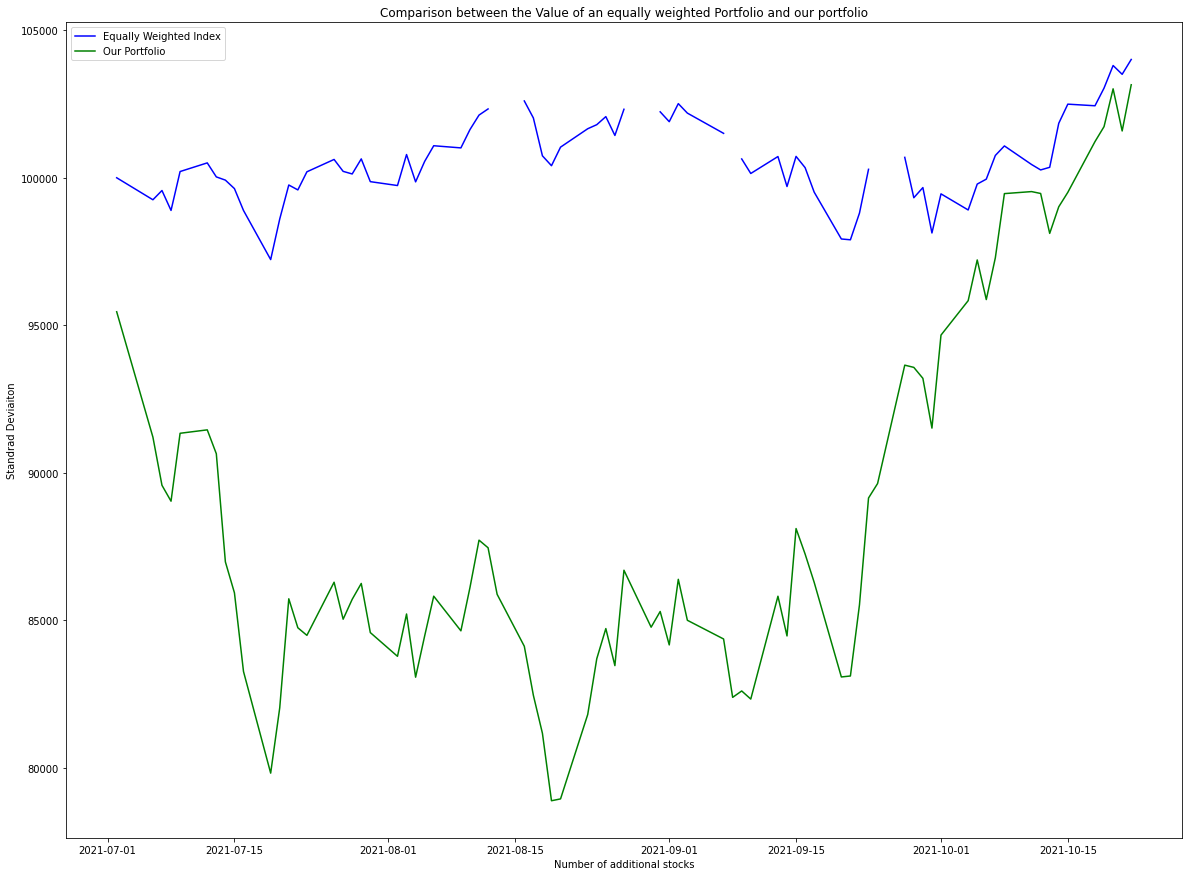

In [213]:
#graphing out portion
plt.figure(figsize=(20,15))

plt.plot(ours_and_equally_weighted.index, ours_and_equally_weighted['Data1'], color='b', label='Equally Weighted Index') 
plt.plot(ours_and_equally_weighted.index, ours_and_equally_weighted['Data2'], color='g', label = "Our Portfolio")
plt.legend(loc='best')
plt.title('Comparison between the Value of an equally weighted Portfolio and our portfolio')
plt.xlabel('Number of additional stocks')
plt.ylabel('Standrad Deviaiton')

As we can see in the graph above, our portfolio is significantly more volatile than the equally weighted portfolio. The initial starting price of our portfolio is slightly different due to the fact that the shares in our shares in our portfolio were purchased based on prices from November 26. However, as we can see the overall influx of the graph is significantly higher suggesting the volatility of our portfolio.

Fromt this, we can conclude that based on past data, our portfolio is significantly more riskier than a randomly chosen portfolio and our weighting as well as our stock selection are curated.

### Step #10: Creating the final portfolio dataframe and csv

In [ ]:
# Show that value adds to $100,000, the weights add to 100%
sum_value = FinalPortfolio['Value'].sum()
sum_weight = FinalPortfolio['Weight'].sum()
print(f'The sum of all Value is ${sum_value}.')
print(f'The sum of all Weight is {sum_weight}%.')

The sum of all Value is $1000000.0.
The sum of all Weight is 100.0%.


In [ ]:
# Creating the output csv
Stocks = FinalPortfolio[['Ticker', 'Shares']]
Stocks.to_csv('Stocks_Group_17.csv')

In [ ]:
# Display the final portfolio
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,OXY,32.119999,10896.637971,350000.0,35.0
2,SLB,32.779999,7626.601870,250000.0,25.0
3,COP,72.139999,693.096762,50000.0,5.0
4,COF,156.549988,319.386802,50000.0,5.0
5,AIG,58.860001,849.473318,50000.0,5.0
6,SPG,165.440002,302.224367,50000.0,5.0
7,AXP,181.300003,275.785985,50000.0,5.0
8,BAC,47.490002,1052.853195,50000.0,5.0
9,USB,60.779999,822.639043,50000.0,5.0
10,BK,59.990002,833.472222,50000.0,5.0


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here. 